# Modelling of Behavioral Data with distorted probabilities

In [1]:
#import re
import os
import pystan
import pandas as pd
import numpy as np
from collections import defaultdict
import pylab as plt
import seaborn as sns
from scipy.stats import beta,norm,pareto

def log_odds(x):
    return np.log(x/(1-x))

def logist(x):
    return 1/(1+np.exp(-x))

def computeWAIC(gam,pnull,y,N,x):
    '''Returns WAIC for extracted gam, pnull from binomial model'''
    from scipy.stats import binom
    pD = 0
    ll = 0
    lppd = 0
    for i in xrange(5):
        for j in xrange(16):
            ll = binom.pmf(y[j,i], N[j,i],
                           logist(x[i]*gam[:,j] + (1-gam[:,j])*log_odds(pnull[:,j])))
            pD = pD + np.var(np.log(ll))
            lppd = lppd + np.log(np.mean(ll))
    WAIC = (-2*(lppd-pD))
    return WAIC

def computeWAIC_components(gam,pnull,y,N,x):
    '''Returns WAIC for extracted gam, pnull from binomial model'''
    from scipy.stats import binom
    pD = 0
    ll = 0
    lppd = 0
    lppd_pD = []
    for i in xrange(5):
        for j in xrange(16):
            ll = binom.pmf(y[j,i], N[j,i],
                           logist(x[i]*gam[:,j] + (1-gam[:,j])*log_odds(pnull[:,j])))
            pD = np.var(np.log(ll))
            lppd = np.log(np.mean(ll))
            lppd_pD.append(lppd-pD)
    return np.array(lppd_pD)


def computeLPPD(gam,pnull,y,N,x):
    '''Returns log-posterior predictive density (LPPD) for extracted gam,pnull from binomial model'''
    from scipy.stats import binom
    ll = 0
    lppd = 0
    for i in xrange(5):
        ll = binom.pmf(y[i], N[i], 
                       logist(x[i]*gam + (1-gam)*log_odds(pnull)))
        lppd = lppd + np.log(np.mean(ll))
    return lppd

def computeLPPD_components(gam,pnull,y,N,x):
    '''Returns log-posterior predictive density (LPPD) for extracted gam,pnull from binomial model'''
    from scipy.stats import binom
    ll = 0
    lppd = []
    for i in xrange(5):
        ll = binom.pmf(y[i], N[i], 
                       logist(x[i]*gam + (1-gam)*log_odds(pnull)))
        lppd.append(np.log(np.mean(ll)))
    return np.array(lppd)


def get_pred(x,gam,pnull):
    return logist(gam*log_odds(x) + (1-gam)*log_odds(pnull)) 


%matplotlib inline
sns.set_style('white')

In [2]:
nopooling_model = '''
data {
int<lower=0> npb;
int<lower=0> cases;
int<lower=0> N[npb,cases];
int<lower=0> y[npb,cases];
real X[cases];
}
parameters {


real<lower=0,upper=1> pzero[npb];
real<lower=0> gam[npb];
}

model {
for (j in 1:npb)
{
gam[j] ~ normal(1,1) T[0,];
pzero[j] ~ beta(1,1);
}
for (i in 1:cases)
{
for (j in 1:npb)
y[j,i] ~ binomial_logit(N[j,i],X[i]*gam[j] + (1-gam[j])*log(pzero[j]/(1-pzero[j])));
}
}
'''

fullpooling_model = '''
data {
int<lower=0> npb;
int<lower=0> cases;
int<lower=0> N[npb,cases];
int<lower=0> y[npb,cases];
real X[cases];
}
parameters {
real<lower=0,upper=1> pzero;
real<lower=0> gam;
}

model {

gam ~ normal(1,1) T[0,];

pzero ~ beta(1,1);


for (i in 1:cases)
{
for (j in 1:npb)
y[j,i] ~ binomial_logit(N[j,i],X[i]*gam + (1-gam)*log(pzero/(1-pzero)));
}
}
'''

hierarchic_model = '''
data {
int<lower=0> npb;
int<lower=0> cases;
int<lower=0> N[npb,cases];
int<lower=0> y[npb,cases];
real X[cases];
}
parameters {

real<lower=0,upper=1> phi;
real<lower=0.1> lambda;
real<lower=0> mu_gam;
real<lower=0> tau_gam;


real<lower=0,upper=1> pzero[npb];
real<lower=0> gam[npb];
}

model {
real alpha;
real beta;
phi ~ beta(1,1);
lambda ~ pareto(0.1,1.5);


alpha <- lambda * phi;
beta <- lambda * (1 - phi);

mu_gam ~ normal(1,1) T[0,];
gam ~ normal(mu_gam,tau_gam);

pzero ~ beta(alpha,beta);


for (i in 1:cases)
{
for (j in 1:npb)
y[j,i] ~ binomial_logit(N[j,i],X[i]*gam[j] + (1-gam[j])*log(pzero[j]/(1-pzero[j])));
}
}
'''

In [3]:

#there are 16 vps
npb = 16
#and 14 (12 without 1st ball) different cases for the binomial distribution
cases = 5
path = '/home/mboos/Work/Bayesian Updating/Old Data/'

freq_urn_cc = np.loadtxt('/home/mboos/Work/Bayesian Updating/Old Data/freq_urn_cc.txt')
rare_urn_cc = np.loadtxt(path+'rare_urn_cc.txt')
freq_urn_uc = np.loadtxt(path+'freq_urn_uc.txt')
rare_urn_uc = np.loadtxt(path+'rare_urn_uc.txt')
freq_urn_uu = np.loadtxt(path+'freq_urn_uu.txt')
rare_urn_uu = np.loadtxt(path+'rare_urn_uu.txt')
freq_urn_cu = np.loadtxt(path+'freq_urn_cu.txt')
rare_urn_cu = np.loadtxt(path+'rare_urn_cu.txt')

N_cc = freq_urn_cc + rare_urn_cc
N_uc = freq_urn_uc + rare_urn_uc
N_cu = freq_urn_cu + rare_urn_cu
N_uu = freq_urn_uu + rare_urn_uu

In [4]:

prior_values = [0.1,0.3]
likelihood_values = [0.9,0.7]

lo_xs = list()

for prior in prior_values:
    for likelihood in likelihood_values:
        posterior = np.array([ (prior*likelihood**i*(1-likelihood)**(4-i)) \
                              / ((prior*likelihood**i*(1-likelihood)**(4-i))+((1-prior)*(1-likelihood)**i*likelihood**(4-i))) for i in xrange(5) ])
        lo_xs.append(np.log(posterior/(1-posterior)))

#create the data-structures
data_cc = {"npb" : npb,"cases":cases,"N":N_cc.astype(int),"y":rare_urn_cc.astype(int),"X":lo_xs[0]}
data_cu = {"npb" : npb,"cases":cases,"N":N_cu.astype(int),"y":rare_urn_cu.astype(int),"X":lo_xs[1]}
data_uc = {"npb" : npb,"cases":cases,"N":N_uc.astype(int),"y":rare_urn_uc.astype(int),"X":lo_xs[2]}
data_uu = {"npb" : npb,"cases":cases,"N":N_uu.astype(int),"y":rare_urn_uu.astype(int),"X":lo_xs[3]}


In [5]:
#create fit objects
fit_parpool = pystan.stan(model_code=hierarchic_model,data=data_cc)
fit_fullpool = pystan.stan(model_code=fullpooling_model,data=data_cc)
fit_nopool = pystan.stan(model_code=nopooling_model,data=data_cc)

KeyboardInterrupt: 

In [36]:
#fit now
WAIC = defaultdict(dict)

for modeltype, modelfit in zip (['full pooling','no pooling','partial pooling'],[fit_fullpool,fit_nopool,fit_parpool]):
    for condition, data in zip(['cc','uc','cu','uu'],[data_cc,data_uc,data_cu,data_uu]):
        fit = pystan.stan(fit=modelfit, data=data,iter=10000, chains=20)
        extr = fit.extract(['gam','pzero'])
        with open('paper_fitdumps/fitdump_{}_{}.txt'.format(modeltype,condition),'w+') as fh:
            print >> fh, fit
        if modeltype == 'full pooling':
            WAIC[modeltype][condition] = computeWAIC(np.tile(extr['gam'][:,None],data['npb'])\
                                         ,np.tile(extr['pzero'][:,None],data['npb']),data['y'],data['N'],data['X'])
        else:
            WAIC[modeltype][condition] = computeWAIC(extr['gam'],extr['pzero'],data['y'],data['N'],data['X'])



/home/mboos/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/home/mboos/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/home/mboos/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/home/mboos/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must b

In [14]:
#computes -2 * leave-one-out cross-validation of the different models

LOCV_LPPD = defaultdict(dict)

for modeltype,modelfit in zip (['full pooling','partial pooling'], [fit_fullpool,fit_parpool]):
    for condition,data in zip(['cc','uc','cu','uu'], [data_cc,data_uc,data_cu,data_uu]):
        lo_lppd = []
        for leftout_subj in xrange(16):
            lo_data = data.copy()
            lo_data['npb'] = 15
            test_y = lo_data['y'][leftout_subj,:]
            test_N = lo_data['N'][leftout_subj,:]
            lo_data['y'] = np.delete(lo_data['y'],obj=leftout_subj,axis=0)
            lo_data['N'] = np.delete(lo_data['N'],obj=leftout_subj,axis=0)
            fit = pystan.stan(fit=modelfit, data=data,iter=10000, chains=20)
            if modeltype == 'full pooling':
                extr = fit.extract(['gam','pzero'])
                lo_lppd.append(computeLPPD(extr['gam'],extr['pzero'],test_y,test_N,data['X']))
            else:
                extr = fit.extract(['mu_gam','phi','tau_gam','lambda'])
                gam = np.random.normal(extr['mu_gam'],extr['tau_gam'])
                alpha = extr['phi'] * extr['lambda']
                beta = extr['lambda'] * (1-extr['phi'])
                pnull = np.random.beta(alpha,beta)
                lo_lppd.append(computeLPPD(gam,pnull,test_y,test_N,data['X']))
        LOCV_LPPD[modeltype][condition] = -2*np.(lo_lppd)
        
joblib.dump(LOCV_LPPD,'locv.pkl',compress=3)

In [20]:
#computes -2 * leave-one-out cross-validation of the different models

LOCV_LPPD = defaultdict(dict)

for modeltype,modelfit in zip (['full pooling','partial pooling'], [fit_fullpool,fit_parpool]):
    for condition,data in zip(['cc','uc','cu','uu'], [data_cc,data_uc,data_cu,data_uu]):
        lo_lppd = []
        for leftout_subj in xrange(16):
            lo_data = data.copy()
            lo_data['npb'] = 15
            test_y = lo_data['y'][leftout_subj,:]
            test_N = lo_data['N'][leftout_subj,:]
            lo_data['y'] = np.delete(lo_data['y'],obj=leftout_subj,axis=0)
            lo_data['N'] = np.delete(lo_data['N'],obj=leftout_subj,axis=0)
            fit = pystan.stan(fit=modelfit, data=data,iter=10000, chains=20)
            if modeltype == 'full pooling':
                extr = fit.extract(['gam','pzero'])
                lo_lppd.append(computeLPPD(extr['gam'],extr['pzero'],test_y,test_N,data['X']))
            else:
                extr = fit.extract(['mu_gam','phi','tau_gam','lambda'])
                gam = np.random.normal(extr['mu_gam'],extr['tau_gam'])
                alpha = extr['phi'] * extr['lambda']
                beta = extr['lambda'] * (1-extr['phi'])
                pnull = np.random.beta(alpha,beta)
                lo_lppd.append(computeLPPD(gam,pnull,test_y,test_N,data['X']))
        LOCV_LPPD[modeltype][condition] = -2*np.array(lo_lppd)
        
#joblib.dump(LOCV_LPPD,'locv.pkl',compress=3)

In [28]:
proportions_cc = rare_urn_cc / N_cc
proportions_cu = rare_urn_cu / N_cu
proportions_uc = rare_urn_uc / N_uc
proportions_uu = rare_urn_uu / N_uu


proportions_list = [proportions_cc, proportions_uc, proportions_cu, proportions_uu]
lo_list = [data['X'] for data in [data_cc, data_uc, data_cu, data_uu]]

In [33]:
unrolled_proportions = [np.array(filter(lambda x : not np.isnan(x[1]),
                                        np.concatenate([zip(logodds, prop_row) for prop_row in proportion])))
                        for proportion, logodds in zip(proportions_list, lo_list)]

unrolled_proportions_df = pd.DataFrame(dict(zip(['log odds', 'proportion'], np.vstack(unrolled_proportions).T)))

unrolled_proportions_df['Prior'] = np.concatenate([np.repeat(pr, prop.shape[0]) for pr, prop in 
                                                   zip(['c', 'u', 'c', 'u'],
                                                        unrolled_proportions)])

unrolled_proportions_df['Likelihood'] = np.concatenate([np.repeat(lkl, prop.shape[0]) for lkl, prop in 
                                                        zip(['c', 'c', 'u', 'u'],
                                                             unrolled_proportions)])

unrolled_proportions_df['optimal proportion'] = logist(unrolled_proportions_df['log odds'])

In [64]:
gammas = dict()
pnulls = dict()

for suffix in ['cc', 'uc', 'cu', 'uu']:
    nopooling = pd.read_csv('/home/mboos/Dropbox/nopool_{}.csv'.format(suffix), skiprows=1)
    gammas[suffix] = nopooling.values[16:32, 1].astype(np.float)
    pnulls[suffix] = nopooling.values[:16, 1].astype(np.float)
    
gamma_df = pd.DataFrame({'gam' : np.concatenate([gammas[cond] for cond in ['cc', 'uc', 'cu', 'uu']]),
                         'prior' : np.concatenate([np.repeat(prior, 16) for prior in ['c', 'u', 'c', 'u']]),
                         'likelihood' : np.concatenate([np.repeat(lkl, 16) for lkl in ['c', 'c', 'u', 'u']]),
                         'subj' : np.tile(np.arange(16), 4)})

pnull_df = pd.DataFrame({'pnull' : np.concatenate([pnulls[cond] for cond in ['cc', 'uc', 'cu', 'uu']]),
                         'prior' : np.concatenate([np.repeat(prior, 16) for prior in ['c', 'u', 'c', 'u']]),
                         'likelihood' : np.concatenate([np.repeat(lkl, 16) for lkl in ['c', 'c', 'u', 'u']]),
                         'subj' : np.tile(np.arange(16), 4)})

model = sm.MixedLM.from_formula('gam ~ prior * likelihood', data=gamma_df, groups=gamma_df['subj']).fit()
model_p0 = sm.MixedLM.from_formula('pnull ~ prior * likelihood', data=pnull_df, groups=pnull_df['subj']).fit()

with open('/home/mboos/Dropbox/gamma_lme.txt','w+') as fh:
    print >> fh, model.summary()

with open('/home/mboos/Dropbox/pnull_lme.txt','w+') as fh:
    print >> fh, model_p0.summary()

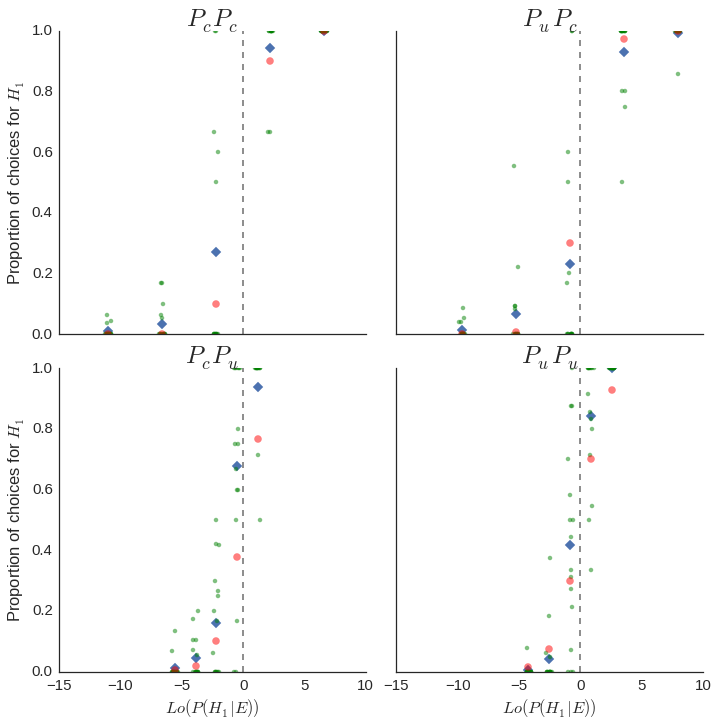

In [35]:
with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.FacetGrid(unrolled_proportions_df, size=5, col='Prior', row='Likelihood', ylim=(0., 1.))
    g.map(sns.regplot, 'log odds', 'proportion', fit_reg=False, ci=None, x_estimator=np.mean, marker='D')
    g.map(sns.regplot, 'log odds', 'proportion', x_jitter=0.25,
               fit_reg=False, marker='o', color='g', scatter_kws={'alpha':0.5})
    g.map(sns.regplot, 'log odds', 'optimal proportion', fit_reg=False, ci=None, x_estimator=np.mean,
          marker='o', color='r', scatter_kws={'alpha':0.5})

    g = g.set_axis_labels(r'$Lo(P(H_1|E))$', r'Proportion of choices for $H_1$')
    g = g.set_titles(r'$P_{col_name} P_{row_name}$', size=25)
    
    for ax in g.axes.flatten():
        ax.axvline(0, alpha=0.5, linestyle='dashed', color='black')
        
    #plt.savefig('Figure7.pdf')
    #plt.savefig('Figure7.svg')

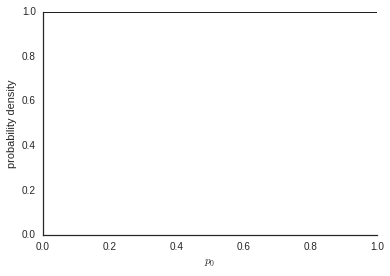

In [10]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,1000),beta.pdf(np.linspace(0,1,1000),a=1,b=1),color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0,1)
plt.ylabel('probability density')
plt.xlabel(r'$p_{0}$')
plt.savefig('prior_p0.pdf')
plt.savefig('prior_p0.eps')

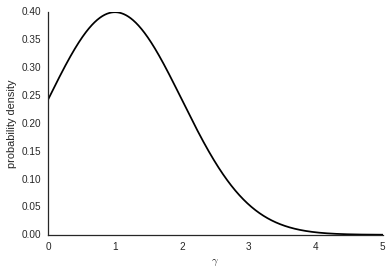

In [11]:
fig,ax = plt.subplots()
ax.plot(np.linspace(0,5,1000),norm.pdf(np.linspace(0,5,1000),1,1),color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('probability density')
plt.xlabel(r'$\gamma$')
plt.savefig('prior_gamma.pdf')
plt.savefig('prior_gamma.eps')

In [12]:
pclc = [0.57,0.76]
pclu = [0.89,0.85]
pulc = [0.54,0.57]
pulu = [1.44,0.15]

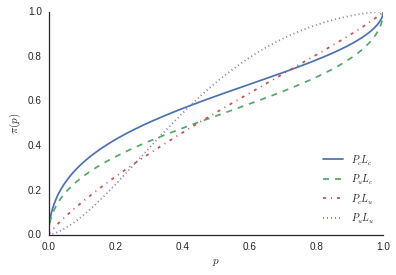

In [14]:
fig,ax = plt.subplots()
plt.hold(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xs = np.linspace(0,1,1000)
ax.plot(xs,get_pred(xs,*pclc),'-',label=r'$P_{c}L_{c}$')
ax.plot(xs,get_pred(xs,*pulc),'--',label=r'$P_{u}L_{c}$')
ax.plot(xs,get_pred(xs,*pclu),'-.',label=r'$P_{c}L_{u}$')
ax.plot(xs,get_pred(xs,*pulu),':',label=r'$P_{u}L_{u}$')
ax.legend(loc=4)
plt.xlabel(r'$p$')
plt.ylabel(r'$\pi(p)$')
plt.savefig('Figure9.eps')
plt.savefig('Figure9.pdf')

In [6]:
nopool_dumps = dict()

for model in ['cc','uc','cu','uu']:
     nopool_dumps[model] = pd.read_table('paper_fitdumps/fitdump_no pooling_{}.txt'.format(model),skiprows=4,delim_whitespace=True)


In [9]:
fullpool_dumps = dict()

for model in ['cc','uc','cu','uu']:
     fullpool_dumps[model] = pd.read_table('paper_fitdumps/fitdump_full pooling_{}.txt'.format(model),skiprows=4,delim_whitespace=True)


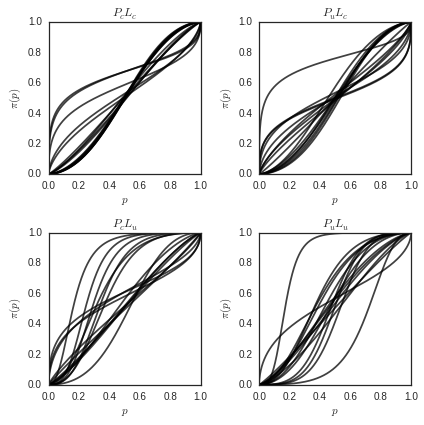

In [81]:
xs = np.linspace(0,1,1000)
with plt.rc_context({'figure.figsize':(6,6)}):
    for i,model in enumerate(['cc','uc','cu','uu']):
        plt.subplot(2,2,i+1)
        plt.hold(True)
        for i in xrange(16):
            plt.plot(xs,get_pred(xs,nopool_dumps[model].values[i+16][0],nopool_dumps[model].values[i][0]),'-',color='k',alpha=0.75)
        plt.xlabel(r'$p$')
        plt.ylabel(r'$\pi(p)$')
        plt.title(r'$P_{%s}L_{%s}$' % (model[0],model[1]))
        plt.hold(False)

    plt.tight_layout()

plt.savefig('Figure10.pdf')
plt.savefig('Figure10.eps')

In [2]:
partpool_dumps = dict()

for model in ['cc','uc','cu','uu']:
     partpool_dumps[model] = pd.read_table('paper_fitdumps/fitdump_partial pooling_{}.txt'.format(model),skiprows=4,delim_whitespace=True)


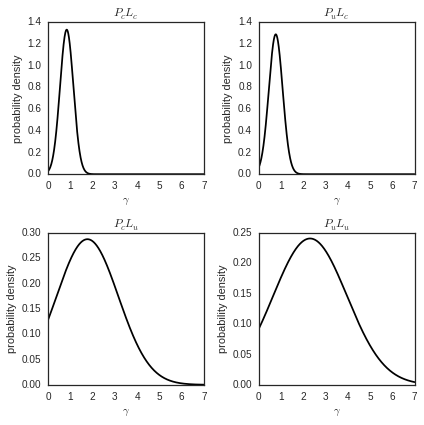

In [93]:
xs = np.linspace(0,7,1000)
with plt.rc_context({'figure.figsize':(6,6)}):
    for i,model in enumerate(['cc','uc','cu','uu']):
        plt.subplot(2,2,i+1)
        plt.plot(xs,norm.pdf(xs,loc=partpool_dumps[model].values[2][0],scale=partpool_dumps[model].values[3][0]),'-',color='k')
        plt.xlabel(r'$\gamma$')
        plt.ylabel('probability density')
        plt.title(r'$P_{%s}L_{%s}$' % (model[0],model[1]))

    plt.tight_layout()
    
plt.savefig('Figure11.pdf')
plt.savefig('Figure11.eps')

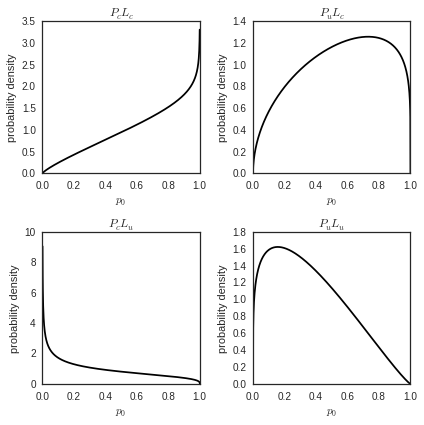

In [97]:
xs = np.linspace(0,1,1000)
with plt.rc_context({'figure.figsize':(6,6)}):
    for i,model in enumerate(['cc','uc','cu','uu']):
        plt.subplot(2,2,i+1)
        phi = partpool_dumps[model].values[0][0]
        lamb = partpool_dumps[model].values[1][0]
        plt.plot(xs,beta.pdf(xs,phi*lamb,(1-phi)*lamb),'-',color='k')
        plt.xlabel(r'$p_{0}$')
        plt.ylabel('probability density')
        plt.title(r'$P_{%s}L_{%s}$' % (model[0],model[1]))

    plt.tight_layout()
    
plt.savefig('Figure12.pdf')
plt.savefig('Figure12.eps')

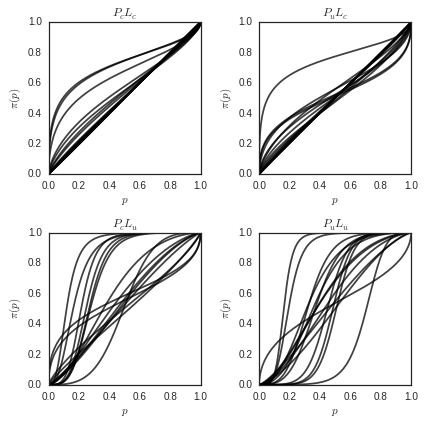

In [106]:
xs = np.linspace(0,1,1000)
with plt.rc_context({'figure.figsize':(6,6)}):
    for i,model in enumerate(['cc','uc','cu','uu']):
        plt.subplot(2,2,i+1)
        plt.hold(True)
        for i in xrange(4,20):
            plt.plot(xs,get_pred(xs,partpool_dumps[model].values[i+16][0],partpool_dumps[model].values[i][0]),'-',color='k',alpha=0.75)
        plt.xlabel(r'$p$')
        plt.ylabel(r'$\pi(p)$')
        plt.title(r'$P_{%s}L_{%s}$' % (model[0],model[1]))
        plt.hold(False)

    plt.tight_layout()

plt.savefig('Figure13.pdf')
plt.savefig('Figure13.eps')